In [1]:
# pip install gputools
# pip install scikit-tensor-py3

from __future__ import print_function, unicode_literals, absolute_import, division
import sys
import numpy as np
import matplotlib
matplotlib.rcParams["image.interpolation"] = 'nearest'
import matplotlib.pyplot as plt
import os
from PIL import Image
import tensorflow as tf
from glob import glob
from tqdm import tqdm
from tifffile import imread
import struct
import cv2
import pandas as pd

from stardist import fill_label_holes, random_label_cmap, calculate_extents, gputools_available
from stardist.models import Config2D, StarDist2D, StarDistData2D

In [2]:
#Random color map labels
np.random.seed(42)
lbl_cmap = random_label_cmap()

In [349]:
pth_models = r''  # place to save models

pth_training_HE = r'\\10.99.68.178\andreex\data\Stardist\Train_Val_Splits\Training\HE_tiles'  # change this later
pth_validation_HE = r'\\10.99.68.178\andreex\data\Stardist\Train_Val_Splits\Validation\HE_tiles'
pth_testing_HE = r'\\10.99.68.178\andreex\data\Stardist\Testing\monkey\tiles'

pth_training_masks = r'\\10.99.68.178\andreex\data\Stardist\Train_Val_Splits\Training\masks'
pth_validation_masks = r'\\10.99.68.178\andreex\data\Stardist\Train_Val_Splits\Validation\masks'
pth_testing_masks = r'\\10.99.68.178\andreex\data\Stardist\Testing\monkey\qupath\ground_truth\masks'

In [350]:
training_HE_tiles_pths = sorted(glob(os.path.join(pth_training_HE,'*.tif')))
training_mask_tiles_pths = sorted(glob(os.path.join(pth_training_masks,'*.tif')))

print(len(training_HE_tiles_pths))
print(len(training_mask_tiles_pths))

27
27


In [351]:
validation_HE_tiles_pths = sorted(glob(os.path.join(pth_validation_HE,'*.tif')))
validation_mask_tiles_pths = sorted(glob(os.path.join(pth_validation_masks,'*.tif')))

print(len(validation_HE_tiles_pths))
print(len(validation_mask_tiles_pths))

12
12


In [352]:
testing_HE_tiles_pths = sorted(glob(os.path.join(pth_testing_HE,'*.tif')))
testing_mask_tiles_pths = sorted(glob(os.path.join(pth_testing_masks,'*.tif')))

print(len(testing_HE_tiles_pths))
print(len(testing_mask_tiles_pths))

36
36


Start making training tiles -> original and augmented

In [353]:
HE_original_tiles = list(map(imread,training_HE_tiles_pths))
mask_original_tiles = list(map(imread,training_mask_tiles_pths))

In [354]:
def augment_images(HE_tiles, mask_tiles):
  """
  Augments a set of HE images and corresponding mask labels by rotating and flipping them.

  Args:
    HE_tiles: A list of NumPy arrays representing the HE images.
    mask_tiles: A list of NumPy arrays representing the mask labels for the HE images.

  Returns:
    HE_aug: A list of NumPy arrays representing the augmented HE images.
    mask_aug: A list of NumPy arrays representing the augmented mask labels.
  """

  HE_aug = [[] for _ in range(len(HE_tiles))]
  mask_aug = [[] for _ in range(len(mask_tiles))]

  for i in range(len(HE_tiles)):
    im = Image.fromarray(HE_tiles[i])
    lbl = Image.fromarray(mask_tiles[i])

    # Rotate the image and label 90 degrees three times.
    for _ in range(3):
      im = im.rotate(90)
      HE_aug[i].append(im)
      lbl = lbl.rotate(90)
      mask_aug[i].append(lbl)

    # Flip the image and label horizontally.
    im = Image.fromarray(HE_tiles[i])
    flipped_im = im.transpose(Image.FLIP_LEFT_RIGHT)

    lbl = Image.fromarray(mask_tiles[i])
    flipped_lbl = lbl.transpose(Image.FLIP_LEFT_RIGHT)

    HE_aug[i].append(flipped_im)
    mask_aug[i].append(flipped_lbl)

    # Rotate the flipped image and label 90 degrees three times.
    for _ in range(3):
      flipped_im = flipped_im.rotate(90)
      HE_aug[i].append(flipped_im)
      flipped_lbl = flipped_lbl.rotate(90)
      mask_aug[i].append(flipped_lbl)

  return HE_aug, mask_aug

In [18]:
HE_aug, mask_aug = augment_images(HE_original_tiles, mask_original_tiles)

In [21]:
print(len(HE_aug))
print(len(HE_aug[0]))
print(len(HE_aug)*len(HE_aug[0]))

28
7
196


In [204]:
HE_trn_tiles_raw = [np.array(im) for im_list in HE_aug for im in im_list]  # flatten
HE_trn_masks = [np.array(im) for im_list in mask_aug for im in im_list]  # flatten

In [205]:
print(len(HE_trn_tiles_raw))
print(len(HE_trn_masks))

196
196


In [206]:
HE_trn_tiles = [im/255 for im in HE_trn_tiles_raw]  # normalize

Make Validation Tiles

In [348]:
HE_val_tiles = list(map(imread,validation_HE_tiles_pths))
HE_val_masks = list(map(imread,validation_mask_tiles_pths))

HE_val_tiles = [np.array(im) for im in HE_val_tiles]

HE_val_tiles = [im/255 for im in HE_val_tiles]  # normalize

Show some images and make sure everything is ok

In [207]:
# Plot image and label for some images - sanity check
def show_tile_segmented(tile, segmented, **kwargs):
    """Plot large image at different resolutions."""
    fig, ax = plt.subplots(1, 2, figsize=(16/2, 8/2))

    # Plot the original image on the left
    ax[0].imshow(tile, **kwargs)

    # Plot the cropped image on the right
    ax[1].imshow(segmented, **kwargs)

    ax[0].axis('off')
    ax[1].axis('off')

    plt.tight_layout()
    plt.show()

i = 0

140


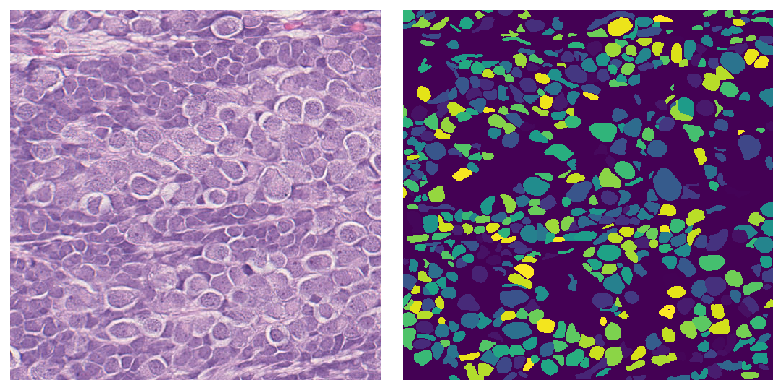

In [347]:
i += 1

print(i)

img, lbl = HE_trn_tiles[i], HE_trn_masks[i]
show_tile_segmented(img,lbl)

In [195]:
if tf.config.list_physical_devices('GPU'):
    print("GPU is available")
else:
    print("GPU is not available")

print(tf.__version__)

#Define the config by setting some parameter values
# 32 is a good default choice (see 1_data.ipynb)
n_rays = 32  #Number of radial directions for the star-convex polygon.

# Use OpenCL-based computations for data generator during training (requires 'gputools')
use_gpu = True and gputools_available()

# Predict on subsampled grid for increased efficiency and larger field of view
grid = (2,2)

n_channel = 1 if np.array(HE_trn_tiles[0]).ndim == 2 else np.array(HE_trn_tiles[0]).shape[-1]  #If no third dim. then number of channels = 1. Otherwise get the num channels from the last dim.


conf = Config2D (
    n_rays       = n_rays,
    grid         = grid,
    use_gpu      = use_gpu,
    n_channel_in = n_channel,
)
# print(conf)
vars(conf)

GPU is available
2.9.3


{'n_dim': 2,
 'axes': 'YXC',
 'n_channel_in': 3,
 'n_channel_out': 33,
 'train_checkpoint': 'weights_best.h5',
 'train_checkpoint_last': 'weights_last.h5',
 'train_checkpoint_epoch': 'weights_now.h5',
 'n_rays': 32,
 'grid': (2, 2),
 'backbone': 'unet',
 'n_classes': None,
 'unet_n_depth': 3,
 'unet_kernel_size': (3, 3),
 'unet_n_filter_base': 32,
 'unet_n_conv_per_depth': 2,
 'unet_pool': (2, 2),
 'unet_activation': 'relu',
 'unet_last_activation': 'relu',
 'unet_batch_norm': False,
 'unet_dropout': 0.0,
 'unet_prefix': '',
 'net_conv_after_unet': 128,
 'net_input_shape': (None, None, 3),
 'net_mask_shape': (None, None, 1),
 'train_shape_completion': False,
 'train_completion_crop': 32,
 'train_patch_size': (256, 256),
 'train_background_reg': 0.0001,
 'train_foreground_only': 0.9,
 'train_sample_cache': True,
 'train_dist_loss': 'mae',
 'train_loss_weights': (1, 0.2),
 'train_class_weights': (1, 1),
 'train_epochs': 400,
 'train_steps_per_epoch': 100,
 'train_learning_rate': 0.0003,


In [198]:
#Start from 40x H&E pre-trained model to the specified directory
import copy
import json

def load_justin_model(folder_to_write_new_model_folder: str, name_for_new_model: str) -> StarDist2D:
    published_model = load_model(r'\\10.99.68.178\andreex\students\Donald Monkey fetus\stardist\Model_00')
    original_thresholds = copy.copy({'prob': published_model.thresholds[0], 'nms': published_model.thresholds[1]})
    configuration = Config2D(n_channel_in=3, grid=(2,2), use_gpu=True, train_patch_size=[256, 256])
    model = StarDist2D(config=configuration, basedir=folder_to_write_new_model_folder, name=name_for_new_model)
    model.keras_model.set_weights(published_model.keras_model.get_weights())
    model.thresholds = original_thresholds
    return model

def load_published_he_model(folder_to_write_new_model_folder: str, name_for_new_model: str) -> StarDist2D:
    published_model = StarDist2D.from_pretrained('2D_versatile_he')
    original_thresholds = copy.copy({'prob': published_model.thresholds[0], 'nms': published_model.thresholds[1]})
    configuration = Config2D(n_channel_in=3, grid=(2,2), use_gpu=True, train_patch_size=[256, 256])
    model = StarDist2D(config=configuration, basedir=folder_to_write_new_model_folder, name=name_for_new_model)
    model.keras_model.set_weights(published_model.keras_model.get_weights())
    model.thresholds = original_thresholds
    return model

def load_model(model_path: str) -> StarDist2D:
    # Load StarDist model weights, configurations, and thresholds
    with open(model_path + '\\config.json', 'r') as f:
        config = json.load(f)
    with open(model_path + '\\thresholds.json', 'r') as f:
        thresh = json.load(f)
    model = StarDist2D(config=Config2D(**config), basedir=model_path, name='offshoot_model')
    model.thresholds = thresh
    print('Overriding defaults:', model.thresholds, '\n')
    model.load_weights(model_path + '\\weights_best.h5')
    return model

def configure_model_for_training(model: StarDist2D,
                                 epochs: int = 25, learning_rate: float = 1e-6,
                                 batch_size: int = 4, patch_size: list[int,int] = [256, 256]) -> StarDist2D:
    model.config.train_epochs = epochs
    model.config.train_learning_rate = learning_rate
    model.config.train_batch_size = batch_size
    model.config.train_patch_size = patch_size
    return model

In [200]:
import itertools

lrs = [5e-4, 1e-3, 3e-3, 5e-3]
epochs_strs = [100, 200, 400]
pts = [10, 20, 30, 40]


# Create a list of all the possible combinations of the hyperparameters
list_trainings = list(itertools.product(lrs, epochs_strs, pts))

losses_best = []
losses_last = []

for i in range(len(list_trainings)):
    lr=list_trainings[i][0]
    epochs=list_trainings[i][1]
    pt=list_trainings[i][2]
    nm='monkey_ft_'
    dt='11_03_2023'
    outnm = nm + dt + '_lr_' + str(lr) + '_epochs_' + str(epochs) + '_pt_' + str(pt)
    print(outnm)
    print(f'({i}/{len(list_trainings)})')

    model = load_published_he_model(pthmodels, outnm)
    model.config.train_learning_rate = lr
    model.config.train_patch_size = (256,256)
    model.config.train_reduce_lr={'factor': 0.5, 'patience': pt, 'min_delta': 0}
    model.train(HE_trn_tiles, HE_trn_masks, validation_data=(HE_val_tiles,HE_val_masks), epochs=epochs, steps_per_epoch=100)
    model.optimize_thresholds(HE_val_tiles,HE_val_masks)

    pth_log_train = fr"\\10.99.68.178\andreex\data\Stardist\models\{outnm}\logs\train"

    pth_log = glob(os.path.join(pth_log_train,'*.v2'))[0]
    loss = get_loss_data(str(pth_log), pth_log_train)

    losses_best.append(min(loss))
    losses_last.append(loss[-1])

monkey_ft_11_03_2023_lr_0.0005_epochs_100_pt_10
(0/48)


NameError: name 'pthmodels' is not defined